## <center>Conventional Methods for Denoising</center>

In [1]:
import torch 

batch = torch.load('noi.pt', map_location=torch.device('cpu'))
real_batch = torch.load('output_orig.pt', map_location=torch.device('cpu'))

In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_tensor_images(tensor_img, num_images = 4, size=(1, 128, 128)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=2)
    plt.figure(figsize=(10,10))
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


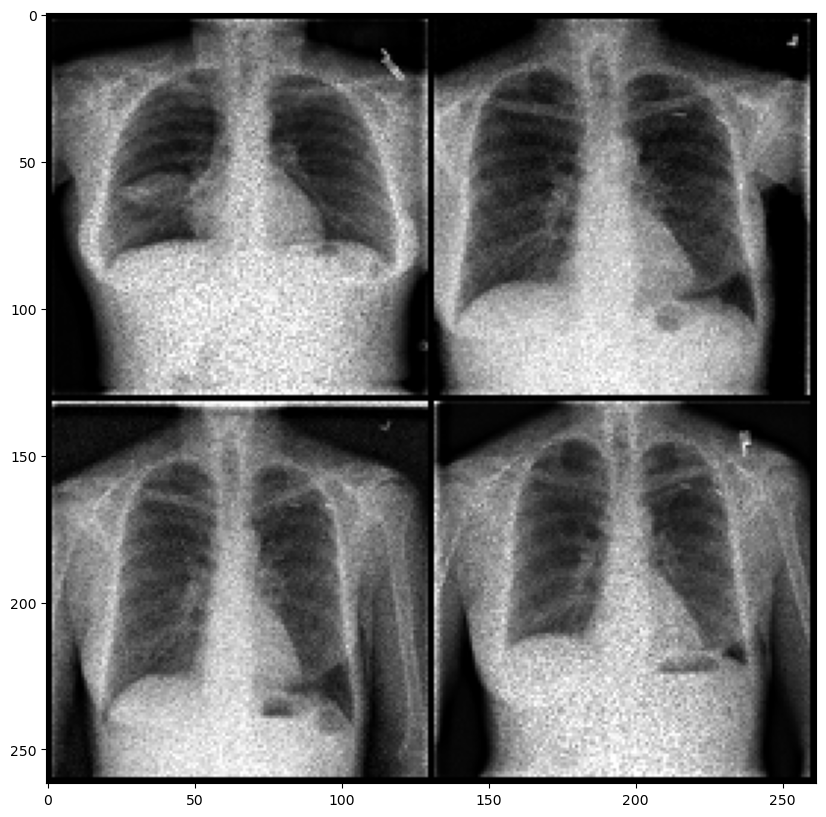

In [5]:
show_tensor_images(batch)

## <center>Bilateral Filtering</center>
<hr/>

In [6]:
from skimage.filters import gaussian

def fspecial_gaussian_2d(size, sigma):
    kernel = np.zeros(tuple(size))
    kernel[size[0]//2, size[1]//2] = 1
    kernel = gaussian(kernel, sigma)
    return kernel/np.sum(kernel)

In [7]:
# Making change in the sample code for bilateral filter

import math

def bilateral2d(img, radius, sigma, sigmaIntensity):
    pad = radius
    # Initialize filtered image to 0
    out = np.zeros_like(img)

    # Pad image to reduce boundary artifacts
    imgPad = np.pad(img, pad)

    # Smoothing kernel, gaussian with standard deviation sigma
    # and size (2*radius+1, 2*radius+1)
    filtSize = (2*radius + 1, 2*radius + 1)
    spatialKernel = fspecial_gaussian_2d(filtSize, sigma)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            centerVal = imgPad[y+pad, x+pad] # Careful of padding amount!

            # Go over a window of size (2*radius + 1) around the current pixel,
            # compute weights, sum the weighted intensity.
            # Don't forget to normalize by the sum of the weights used.
            
            # initializing a weighted intensity array, which will store the value of weights while computing
            weighted_intensity = np.zeros((spatialKernel.shape[0], spatialKernel.shape[1]))
            for r in range(0, 2 * radius+1):
                for c in range(0, 2 * radius+1):
                    current_r = r - radius + y + pad
                    current_c = c - radius + x + pad
                    
                    # Using the formula e^(-x^2 / 2 * sigmaI^2)
                    weighted_intensity[r, c] = math.exp(
                        (-1) * (
                        (imgPad[current_r][current_c] - centerVal)**2) / (2 * math.pow(sigmaIntensity,2)
                    ))

            # getting final bilateral kernel which will be multiplied with the 
            # image pixels to get the missing value        
            bilateral_kernel = weighted_intensity * spatialKernel
            
            
            # dividing by sum of kernel values to normalize the output
            out[y, x] =  np.sum(np.multiply(imgPad[
                y + pad - radius: y + pad + radius + 1, 
                x + pad - radius: x + pad + radius + 1], 
                bilateral_kernel))/np.sum(bilateral_kernel)
    return out 

In [8]:
import torch
import numpy as np
import cv2

def get_bilateral_batch(sigma):

    batch_np = batch.detach().numpy()
    bilateral_batch = torch.zeros(len(batch_np), 1, 128, 128).to('cpu')

    for image_index in range(len(batch_np)):
        image = batch_np[image_index].reshape((128,128))

        rgb_image = np.stack((image,)*3, axis=-1)

        bilateral = np.zeros_like(rgb_image)

        for channel in [0, 1, 2]:
            bilateral[..., channel] = bilateral2d(rgb_image[..., channel],
                                                  radius=int(sigma),
                                                  sigma=sigma,
                                                  sigmaIntensity=0.5) 

        output_image = bilateral[:, :, 0].reshape((1, 128, 128))

        bilateral_batch[image_index] = torch.Tensor(output_image)
        
    return bilateral_batch

In [13]:
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

def calculate_batch_psnr(fake_image,real_image):
    psnr = PeakSignalNoiseRatio().to('cpu')
    p = psnr(fake_image, real_image)
    return p

def calculate_batch_ssim(fake_image, real_image):
    ssim = StructuralSimilarityIndexMeasure().to('cpu')
    s = ssim(fake_image, real_image)
    return s

In [14]:
bilateral_sigma_1 = get_bilateral_batch(1)
bilateral_sigma_2 = get_bilateral_batch(2)
bilateral_sigma_3 = get_bilateral_batch(3)

In [15]:
bilateral_psnr_1 = calculate_batch_psnr(bilateral_sigma_1, real_batch)
bilateral_ssim_1 = calculate_batch_ssim(bilateral_sigma_1.type(torch.DoubleTensor), real_batch.type(torch.DoubleTensor))

bilateral_psnr_2 = calculate_batch_psnr(bilateral_sigma_2, real_batch)
bilateral_ssim_2 = calculate_batch_ssim(bilateral_sigma_2.type(torch.DoubleTensor), real_batch.type(torch.DoubleTensor))

bilateral_psnr_3 = calculate_batch_psnr(bilateral_sigma_3, real_batch)
bilateral_ssim_3 = calculate_batch_ssim(bilateral_sigma_3.type(torch.DoubleTensor), real_batch.type(torch.DoubleTensor))

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [16]:
print(bilateral_psnr_1)
print(bilateral_psnr_2)
print(bilateral_psnr_3)

tensor(30.7900, dtype=torch.float64)
tensor(27.8929, dtype=torch.float64)
tensor(25.9166, dtype=torch.float64)


In [17]:
print(bilateral_ssim_1)
print(bilateral_ssim_2)
print(bilateral_ssim_3)

tensor(0.8980)
tensor(0.8826)
tensor(0.8296)


## <center>NLM Filtering</center>
<hr />

In [18]:
def inbounds(img, y, x):
    return 0 <= y and y < img.shape[0] and \
           0 <= x and x < img.shape[1]

def comparePatches(patch1, patch2, kernel, sigma):
    return np.exp(-np.sum(kernel*(patch1 - patch2) ** 2)/(2*sigma**2))

def nonlocalmeans(img, searchWindowRadius, averageFilterRadius, sigma, nlmSigma):
    # Initialize output to 0
    out = np.zeros_like(img)
    # Pad image to reduce boundary artifacts
    pad = max(averageFilterRadius, searchWindowRadius)
    imgPad = np.pad(img, pad)
    imgPad = imgPad[..., pad:-pad] # Don't pad third channel

    # Smoothing kernel
    filtSize = (2*averageFilterRadius + 1, 2*averageFilterRadius + 1)
    kernel = fspecial_gaussian_2d(filtSize, sigma)
    # Add third axis for broadcasting
    kernel = kernel[:, :, np.newaxis]
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            centerPatch = imgPad[y+pad-averageFilterRadius:y+pad+averageFilterRadius+1,
                                 x+pad-averageFilterRadius:x+pad+averageFilterRadius+1,
                                 :]
            # Go over a window around the current pixel, compute weights
            # based on difference of patches, sum the weighted intensity
            # Hint: Do NOT include the patches centered at the current pixel
            # in this loop, it will throw off the weights
            weights = np.zeros((2*searchWindowRadius+1, 2*searchWindowRadius+1, 1))


            # This makes it a bit better: Add current pixel as well with max weight
            # computed from all other neighborhoods.

            for r in range(-searchWindowRadius, searchWindowRadius+1):
                for c in range(-searchWindowRadius, searchWindowRadius+1):
                    start_row = y+pad+r-averageFilterRadius
                    start_col = x+pad+c-averageFilterRadius
                    end_row = y+pad+r+averageFilterRadius+1
                    end_col = x+pad+c+averageFilterRadius+1
                    
                    # Checking not going out of bound and don't compute on center patch
                    if r != 0 and c != 0 and inbounds(imgPad, start_row, start_col) and inbounds(imgPad, end_row, end_col):
                        
                        patch = imgPad[
                            start_row: end_row, 
                            start_col: end_col, 
                            :]
                        
                        # getting new weight to be assigned to neighbourhood and saving it in an array
                        new_weight = comparePatches(centerPatch, patch, kernel, nlmSigma)
                        weights[r+searchWindowRadius, c+searchWindowRadius, 0] = new_weight
             
            # Max weight to be used by centerPatch
            max_weight = np.amax(weights)
            weights[searchWindowRadius, searchWindowRadius] = max_weight
            
            # Normalizing the weights
            weights = weights/np.sum(weights)
            neighbourhood = imgPad[y+pad-searchWindowRadius: y+pad+searchWindowRadius+1, x+pad-searchWindowRadius: x+pad+searchWindowRadius+1,:]
            
            result = np.multiply(weights, neighbourhood)

            out[y, x, :] = np.sum(result, axis=(0,1)) 
    return out

In [19]:
def get_nlm_batch(sigma):

    batch_np = batch.detach().numpy()
    nlm_batch = torch.zeros(len(batch_np), 1, 128, 128).to('cpu')

    for image_index in range(len(batch_np)):
        image = batch_np[image_index].reshape((128,128))

        rgb_image = np.stack((image,)*3, axis=-1)

        nlm = np.zeros_like(rgb_image)

        nlmSigma = 0.1
        searchWindowRadius = 2
        averageFilterRadius = int(sigma)

        for channel in [0,1,2]:
            nlm[...,channel:channel+1] = nonlocalmeans(rgb_image[..., channel:channel+1],
                                                       searchWindowRadius,
                                                       averageFilterRadius,
                                                       sigma,
                                                       nlmSigma)

        output_image = nlm[:, :, 0].reshape((1, 128, 128))

        nlm_batch[image_index] = torch.Tensor(output_image)
    
    return nlm_batch

In [20]:
nlm_sigma_1 = get_nlm_batch(1)
nlm_sigma_2 = get_nlm_batch(2)
nlm_sigma_3 = get_nlm_batch(3)

In [21]:
nlm_psnr_1 = calculate_batch_psnr(nlm_sigma_1, real_batch)
nlm_ssim_1 = calculate_batch_ssim(nlm_sigma_1.type(torch.DoubleTensor), real_batch.type(torch.DoubleTensor))

nlm_psnr_2 = calculate_batch_psnr(nlm_sigma_2, real_batch)
nlm_ssim_2 = calculate_batch_ssim(nlm_sigma_2.type(torch.DoubleTensor), real_batch.type(torch.DoubleTensor))

nlm_psnr_3 = calculate_batch_psnr(nlm_sigma_3, real_batch)
nlm_ssim_3 = calculate_batch_ssim(nlm_sigma_3.type(torch.DoubleTensor), real_batch.type(torch.DoubleTensor))

In [22]:
print(nlm_psnr_1)
print(nlm_psnr_2)
print(nlm_psnr_3)

tensor(27.8529, dtype=torch.float64)
tensor(28.0265, dtype=torch.float64)
tensor(28.1530, dtype=torch.float64)


In [23]:
print(nlm_ssim_1)
print(nlm_ssim_2)
print(nlm_ssim_3)

tensor(0.8656)
tensor(0.8491)
tensor(0.8423)


## <center>Gaussian Kernel Filtering</center>
<hr />

In [26]:
import scipy.signal

def get_gaussian_batch(sigma): 
    batch_np = batch.detach().numpy()
    gaussian_batch = torch.zeros(len(batch_np), 1, 128, 128).to('cpu')

    for image_index in range(len(batch_np)):
        image = batch_np[image_index].reshape((128,128))

        noisy_image = np.stack((image,)*3, axis=-1)

        # creating the kernel using fspecial_gaussian_2d
        kernel = fspecial_gaussian_2d((9,9), sigma)

        # seperating the three channels
        noisy_image_red = noisy_image[:,:,0]
        noisy_image_green = noisy_image[:,:,1]
        noisy_image_blue = noisy_image[:,:,2]

        # convolving each channel with the gaussian kernel
        new_image_r = scipy.signal.convolve2d(noisy_image_red, kernel, mode="same")
        new_image_g = scipy.signal.convolve2d(noisy_image_green, kernel, mode="same")
        new_image_b = scipy.signal.convolve2d(noisy_image_blue, kernel, mode="same")

        # final image obtained by combining the three channels
        new_image = np.dstack((new_image_r, new_image_g, new_image_b))

        output_image = new_image[:, :, 0].reshape((1, 128, 128))

        gaussian_batch[image_index] = torch.Tensor(output_image)
    
    return gaussian_batch

In [27]:
gaussian_sigma_0_point_5 = get_gaussian_batch(0.5)
gaussian_sigma_1 = get_gaussian_batch(1)
gaussian_sigma_2 = get_gaussian_batch(2)

In [29]:
gaussian_psnr_0_point_5 = calculate_batch_psnr(gaussian_sigma_0_point_5, real_batch)
gaussian_ssim_0_point_5 = calculate_batch_ssim(gaussian_sigma_0_point_5.type(torch.DoubleTensor), real_batch.type(torch.DoubleTensor))

gaussian_psnr_1 = calculate_batch_psnr(gaussian_sigma_1, real_batch)
gaussian_ssim_1 = calculate_batch_ssim(gaussian_sigma_1.type(torch.DoubleTensor), real_batch.type(torch.DoubleTensor))

gaussian_psnr_2 = calculate_batch_psnr(gaussian_sigma_2, real_batch)
gaussian_ssim_2 = calculate_batch_ssim(gaussian_sigma_2.type(torch.DoubleTensor), real_batch.type(torch.DoubleTensor))

In [30]:
print(gaussian_psnr_0_point_5)
print(gaussian_psnr_1)
print(gaussian_psnr_2)

tensor(29.5939, dtype=torch.float64)
tensor(27.1534, dtype=torch.float64)
tensor(23.6335, dtype=torch.float64)


In [31]:
print(gaussian_ssim_0_point_5)
print(gaussian_ssim_1)
print(gaussian_ssim_2)

tensor(0.8258)
tensor(0.9021)
tensor(0.8298)


## <center>Median Filter Denoising</center>
<hr />

In [32]:
import scipy.signal

def get_median_filter_batch(filter_size): 
    batch_np = batch.detach().numpy()
    median_batch = torch.zeros(len(batch_np), 1, 128, 128).to('cpu')

    for image_index in range(len(batch_np)):
        image = batch_np[image_index].reshape((128,128))

        noisy_image = np.stack((image,)*3, axis=-1)

        noisy_image_red = noisy_image[:, :, 0]
        noisy_image_green = noisy_image[:, :, 1]
        noisy_image_blue = noisy_image[:, :, 2]

        new_image_median_r = scipy.ndimage.median_filter(noisy_image_red, size=filter_size)
        new_image_median_g = scipy.ndimage.median_filter(noisy_image_green, size=filter_size)
        new_image_median_b = scipy.ndimage.median_filter(noisy_image_blue, size=filter_size)

        # Combining all the channels
        new_image_median = np.dstack((new_image_median_r, new_image_median_g, new_image_median_b))

        output_image = new_image_median[:, :, 0].reshape((1, 128, 128))
        
        median_batch[image_index] = torch.Tensor(output_image)
    
    return median_batch

In [45]:
median_size_6 = get_median_filter_batch(6)
median_size_7 = get_median_filter_batch(7)
median_size_8 = get_median_filter_batch(8)

In [46]:
median_psnr_6 = calculate_batch_psnr(median_size_6, real_batch)
median_ssim_6 = calculate_batch_ssim(median_size_6.type(torch.DoubleTensor), real_batch.type(torch.DoubleTensor))

median_psnr_7 = calculate_batch_psnr(median_size_7, real_batch)
median_ssim_7 = calculate_batch_ssim(median_size_7.type(torch.DoubleTensor), real_batch.type(torch.DoubleTensor))

median_psnr_8 = calculate_batch_psnr(median_size_8, real_batch)
median_ssim_8 = calculate_batch_ssim(median_size_8.type(torch.DoubleTensor), real_batch.type(torch.DoubleTensor))

In [47]:
print(median_psnr_6)
print(median_psnr_7)
print(median_psnr_8)

tensor(26.4288, dtype=torch.float64)
tensor(26.7938, dtype=torch.float64)
tensor(25.2017, dtype=torch.float64)


In [48]:
print(median_ssim_6)
print(median_ssim_7)
print(median_ssim_8)

tensor(0.8283)
tensor(0.8223)
tensor(0.7852)
